# Feature Selection and Evaluating Multiple Algorithms using SciKit Learn

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthBegin


import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, SGDRegressor, Lasso, Lars, ARDRegression, BayesianRidge, LassoLars, OrthogonalMatchingPursuit, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.feature_selection import RFE, SelectFromModel, VarianceThreshold, SelectKBest, mutual_info_regression, f_regression, RFECV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, normalize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR, LinearSVR


from tqdm import tqdm
import holidays
import datetime
from itertools import combinations

## Create Feature Generator Class

In [2]:
class FeatureGenerator:

    def __init__(self, x, x_dt):
        self.x = x
        self.x_dt = x_dt
        self.interactions = None
        self.lag_features = None
        self.window_features = None
        self.change_features = None
        self.date_features = None
        self.days_features = None
        self.new_x = None
        
    def create_interactions(self):
        interactions = PolynomialFeatures(interaction_only=True)
        new_features = interactions.fit_transform(self.x.fillna(0))
        old_cols = list(self.x.columns)
        new_cols = [':'.join(x) for x in combinations(self.x.columns, r=2)]
        
        # first col from polynomials is constant; dropping
        df = pd.DataFrame(new_features).iloc[:, 1:]
        df.columns = old_cols + new_cols
        
        self.interactions = df.to_dict(orient='list')
        return df            

    def create_lag_features(self, n_lags):
        new_features = {}
        for col in self.x.columns:
            for lag in range(1, n_lags+1):
                col_name = col + f'_lag{lag}'
                col_value = x[col].shift(lag)
                new_features[col_name] = col_value

        self.lag_features = new_features
        df = pd.DataFrame(new_features)
        return df

    def create_window_features(self, window_lengths):
        funcs = {
        'sum': np.sum,
        'mean': np.mean,
        'std': np.std,
        'min': np.min,
        'max': np.max,
        }

        new_features = {}
        for col in self.x.columns:
            for window in window_lengths:
                for func_name, func_call in funcs.items():
                    col_name = col + f'_rolling_{window}_period_{func_name}'
                    col_value = x[col].rolling(window).apply(func_call, raw=False)
                    new_features[col_name] = col_value

        self.window_features = new_features
        df = pd.DataFrame(new_features)
        return df

    def create_change_features(self, period_lengths):
        new_features = {}
        for col in self.x.columns:
            for period in period_lengths:

                col_name = col + f'_{period}_period_pct_chg'
                col_value = x[col].pct_change(periods=period)
                new_features[col_name] = col_value

                col_name = col + f'_{period}_period_diff'
                col_value = x[col].diff(periods=period)
                new_features[col_name] = col_value

        self.change_features = new_features
        df = pd.DataFrame(new_features)
        return df

    def create_date_features(self, dt_format=None):
        new_features = {}

        if dt_format is not None:
            x_dt = pd.to_datetime(self.x_dt, format=dt_format)
        else:
            x_dt = pd.to_datetime(self.x_dt)

        new_features['day'] = x_dt.dt.day
        new_features['week'] = x_dt.dt.week
        new_features['month'] = x_dt.dt.month
        new_features['quarter'] = x_dt.dt.quarter
        new_features['year'] = x_dt.dt.year

        self.date_features = new_features
        df = pd.DataFrame(new_features)
        return df

    def create_days_features(self, dt_format=None):
        new_features = {}

        if dt_format is not None:
            x_dt = pd.to_datetime(self.x_dt, format=dt_format)
        else:
            x_dt = pd.to_datetime(self.x_dt)

        holiday_years = list(range(2000, 2050))
        us_holidays = [x for x in holidays.US(years=holiday_years)]

        def get_bus_days(dt):
            eom = dt
            bom = eom - MonthBegin()
            bus_days = np.busday_count(bom.date(), eom.date(), holidays=us_holidays)
            return bus_days

        new_features['days'] = x_dt.dt.daysinmonth
        new_features['bus_days'] = x_dt.apply(get_bus_days)

        self.days_features = new_features
        df = pd.DataFrame(new_features)
        return df


    def create_all_x(self, n_lags, window_lengths, period_lengths, add_dt=False):
        x_interactions = self.create_interactions()
        x_lags = self.create_lag_features(n_lags)
        x_windows = self.create_window_features(window_lengths)
        x_changes = self.create_change_features(period_lengths)

        if add_dt:
            x_date = self.create_date_features()
            x_days = self.create_days_features()
            df = pd.concat([x_interactions, x_lags, x_windows, x_changes, x_date, x_days], axis=1)
        else:
            df = pd.concat([x_interactions, x_lags, x_windows, x_changes], axis=1)

        self.new_x = df
        return df

    def merge_xy(self, y, drop_na=True):
        df = pd.concat([y, self.new_x], axis=1)
        if drop_na:
            df.dropna(inplace=True)
            df.reset_index(inplace=True, drop=True)

        x = df.iloc[:, 1:]
        y = df.iloc[:, 0]
        return x, y


## Create Time Series Splitter

In [3]:
class TimeSeriesWindows:

    def __init__(self, train_length, test_length, gap_length=None):

        self.train_length = train_length
        self.test_length = test_length
        self.gap_length = gap_length

    def split(self, x, y):

        windows = []

        for i in range(len(x)):

            train_start = i
            train_end = i + self.train_length
            if self.gap_length is not None:
                test_start = train_end + self.gap_length
            else:
                test_start = train_end
            test_end = test_start + self.test_length

            if test_end <= len(x):
                x_train = x.iloc[train_start:train_end]
                y_train = y.iloc[train_start:train_end]
                x_test = x.iloc[test_start:test_end]
                y_test = y.iloc[test_start:test_end]

                split = x_train, x_test, y_train, y_test
                windows.append(split)

        return windows

## Create Feature List Class

In [4]:
class FeatureLists:
    
    def __init__(self):
        self.feature_set = {}
        
    def add_feature_set(self, set_name, train_set, test_set):
        features = {
            'train': train_set,
            'test': test_set
        }
        self.feature_set[set_name] = features

# Feature Engineering and Selection

## Generate Features

In [18]:
df = pd.read_csv('Myexport_change.csv', usecols=[x for x in range(7)])

x_dt = df.iloc[:, 0]
x = df.iloc[:, 1:6]
# 10yr and FF are highly collinear
# creating new spread variable and dropping individual variables
x['Spread'] = x['10yr'] - x['FF']
x.drop(['FF', '10yr'], axis=1, inplace=True)
y = df.iloc[:, 6]

lags = 4
windows = [4, 6, 8]
periods = [1, 2, 3, 4, 8]
test_length = 30

feature_gen = FeatureGenerator(x, x_dt)
feature_gen.create_all_x(lags, windows, periods, add_dt=True)
x, y = feature_gen.merge_xy(y)

x_train, x_test = x.iloc[:-test_length, :], x.iloc[-test_length:, :]
y_train, y_test = y.iloc[:-test_length], y.iloc[-test_length:]

features = FeatureLists()
features.add_feature_set('y', y_train, y_test)
features.add_feature_set('x', x_train, x_test)

## Baseline Regression

Train RMSE: 0.40720563559236356
Test RMSE: 1.6761303761605704
Train R^2: 0.9959228754301958
Residuals Mean: -1.850371707708594e-17


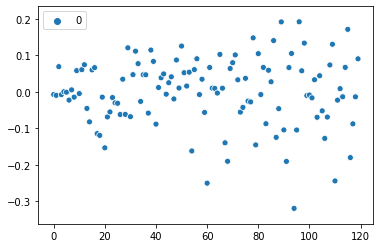

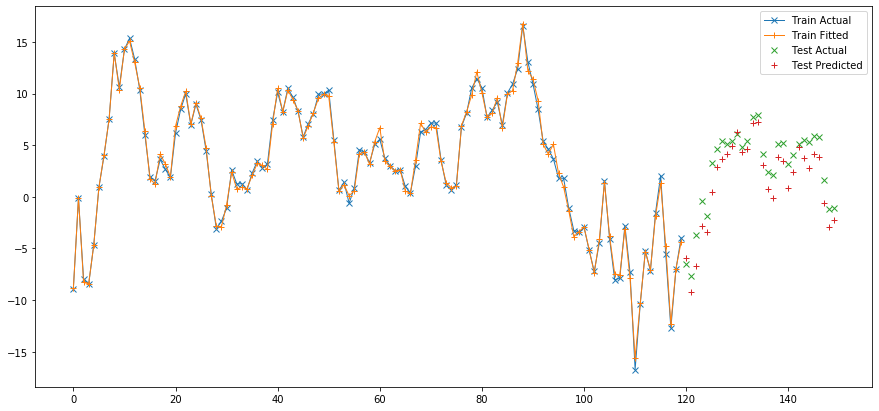

In [19]:
x_train, x_test = features.feature_set['x']['train'], features.feature_set['x']['test']

pl = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]
)

pl.fit(x_train, y_train)

y_fit = pl.predict(x_train)
train_mse = mean_squared_error(y_train, y_fit)
train_rmse = np.sqrt(train_mse)

y_pred = pl.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

train_r_sqd = pl.score(x_train, y_train)
train_resid = y_train - y_fit
norm_resid = normalize(train_resid.values.reshape(-1, 1), axis=0)

res = {
    'Train RMSE': np.sqrt(train_mse),
    'Test RMSE': np.sqrt(test_mse),
    'Train R^2': pl.score(x_train, y_train),
    'Residuals Mean': norm_resid.mean()
}

sns.scatterplot(data=norm_resid)

for metric, result in res.items():
    print(f'{metric}: {result}')
    
plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')
plt.plot(x_test.index, y_test, marker='x', linewidth=0, label='Test Actual')
plt.plot(x_test.index, y_pred, marker='+', linewidth=0, label='Test Predicted')
plt.legend()
plt.show()

## Univariate Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.  
`SelectKBest` removes all but the  highest scoring features

In [20]:
x_train, x_test = features.feature_set['x']['train'], features.feature_set['x']['test']

score_func = mutual_info_regression
selector = SelectKBest(score_func=score_func, k=10)
selector.fit(x_train, y_train)
univariate_features = x_train.columns[selector.get_support()]
print(univariate_features)
features.add_feature_set('kbest10_x', x_train[univariate_features], x_test[univariate_features])

Index(['Unemp', 'Spread', 'HPI:Spread', 'Unemp:Spread', 'Unemp_lag1',
       'HPI_rolling_4_period_min', 'HPI_rolling_6_period_min',
       'Unemp_rolling_4_period_max', 'Unemp_rolling_6_period_max', 'year'],
      dtype='object')


Train RMSE: 1.8328647223276557
Test RMSE: 1.1840488302719323
Train R^2: 0.9173986309044035
Residuals Mean: -1.1102230246251566e-17


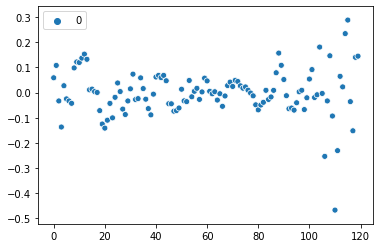

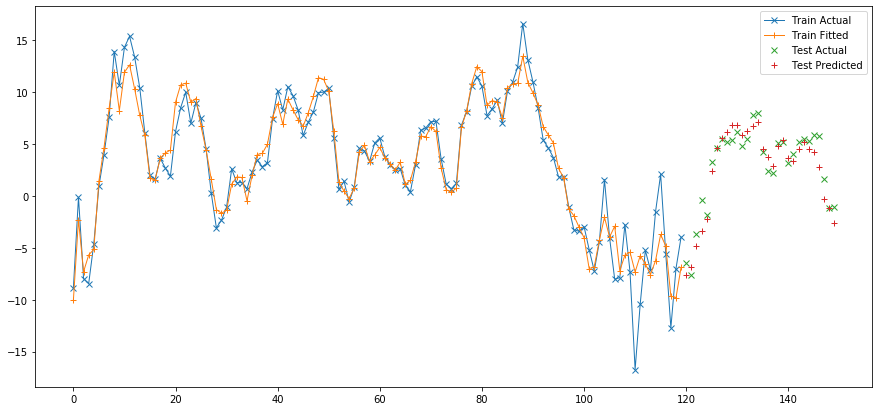

In [21]:
x_train, x_test = features.feature_set['kbest10_x']['train'], features.feature_set['kbest10_x']['test']

pl = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]
)

pl.fit(x_train, y_train)

y_fit = pl.predict(x_train)
train_mse = mean_squared_error(y_train, y_fit)
train_rmse = np.sqrt(train_mse)

y_pred = pl.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

train_r_sqd = pl.score(x_train, y_train)
train_resid = y_train - y_fit
norm_resid = normalize(train_resid.values.reshape(-1, 1), axis=0)

res = {
    'Train RMSE': np.sqrt(train_mse),
    'Test RMSE': np.sqrt(test_mse),
    'Train R^2': pl.score(x_train, y_train),
    'Residuals Mean': norm_resid.mean()
}

sns.scatterplot(data=norm_resid)

for metric, result in res.items():
    print(f'{metric}: {result}')
    
plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')
plt.plot(x_test.index, y_test, marker='x', linewidth=0, label='Test Actual')
plt.plot(x_test.index, y_pred, marker='+', linewidth=0, label='Test Predicted')
plt.legend()
plt.show()

In [22]:
def find_k(x, y, max_k, model=LinearRegression()):
    x_train, x_test = x.iloc[:-test_length, :], x.iloc[-test_length:, :]
    y_train, y_test = y.iloc[:-test_length], y.iloc[-test_length:]
    
    train_scores = []
    test_scores = []
    score_func = mutual_info_regression
    
    k_features = np.arange(1, max_k+1)  
    for k in k_features:
        selector = SelectKBest(score_func=score_func, k=k)
        selector.fit(x_train, y_train)
        
        univariate_features = x_train.columns[selector.get_support()]
        new_x_train, new_x_test = x_train[univariate_features], x_test[univariate_features]
        
        pl = Pipeline(
            [
                ('scaler', StandardScaler()),
                ('model', model)
            ]
        )

        pl.fit(new_x_train, y_train)

        y_fit = pl.predict(new_x_train)
        train_mse = mean_squared_error(y_train, y_fit)
        train_rmse = np.sqrt(train_mse)

        y_pred = pl.predict(new_x_test)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = np.sqrt(test_mse)
        
        train_scores.append(train_rmse)
        test_scores.append(test_rmse)
        
    return train_scores, test_scores

In [23]:
train_scores, test_scores = find_k(x, y, max_k=50, model=Ridge())

Best score: 0.950082196776583.  Best k: 45


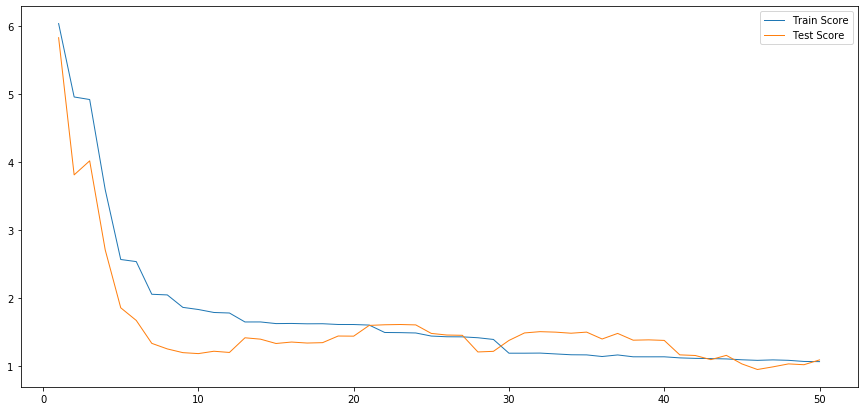

In [24]:
best_score = min(test_scores)
best_k = test_scores.index(best_score)
print(f'Best score: {best_score}.  Best k: {best_k}')

x_idx = np.arange(1, 51)
plt.figure(figsize=(15, 7))
plt.plot(x_idx, train_scores, linewidth=1, label='Train Score')
plt.plot(x_idx, test_scores, linewidth=1, label='Test Score')
plt.legend()
plt.show()

In [25]:
x_train, x_test = features.feature_set['x']['train'], features.feature_set['x']['test']

score_func = mutual_info_regression
selector = SelectKBest(score_func=score_func, k=best_k)
selector.fit(x_train, y_train)
univariate_features = x_train.columns[selector.get_support()]
print(univariate_features)
features.add_feature_set('kbest_x', x_train[univariate_features], x_test[univariate_features])

Index(['Unemp', 'Spread', 'HPI:Spread', 'Unemp:Spread', 'gdp:Spread',
       'HPI_lag2', 'Unemp_lag1', 'Unemp_lag2', 'Unemp_lag3', 'Unemp_lag4',
       'Spread_lag1', 'HPI_rolling_4_period_sum', 'HPI_rolling_4_period_mean',
       'HPI_rolling_4_period_std', 'HPI_rolling_4_period_min',
       'HPI_rolling_6_period_sum', 'HPI_rolling_6_period_mean',
       'HPI_rolling_6_period_min', 'HPI_rolling_8_period_sum',
       'HPI_rolling_8_period_mean', 'HPI_rolling_8_period_std',
       'Unemp_rolling_4_period_sum', 'Unemp_rolling_4_period_mean',
       'Unemp_rolling_4_period_min', 'Unemp_rolling_4_period_max',
       'Unemp_rolling_6_period_max', 'Unemp_rolling_8_period_min',
       'Unemp_rolling_8_period_max', 'gdp_rolling_6_period_sum',
       'gdp_rolling_6_period_mean', 'gdp_rolling_8_period_sum',
       'gdp_rolling_8_period_mean', 'gdp_rolling_8_period_std',
       'gdp_rolling_8_period_min', 'Spread_rolling_4_period_sum',
       'Spread_rolling_4_period_mean', 'Spread_rolling_4_peri

Train RMSE: 1.0981805789274206
Test RMSE: 0.9640993638675679
Train R^2: 0.9703466380135617
Residuals Mean: -8.326672684688674e-18


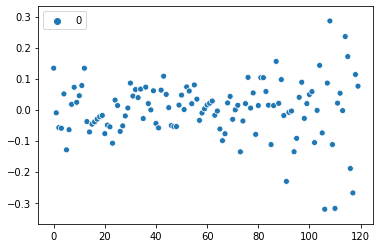

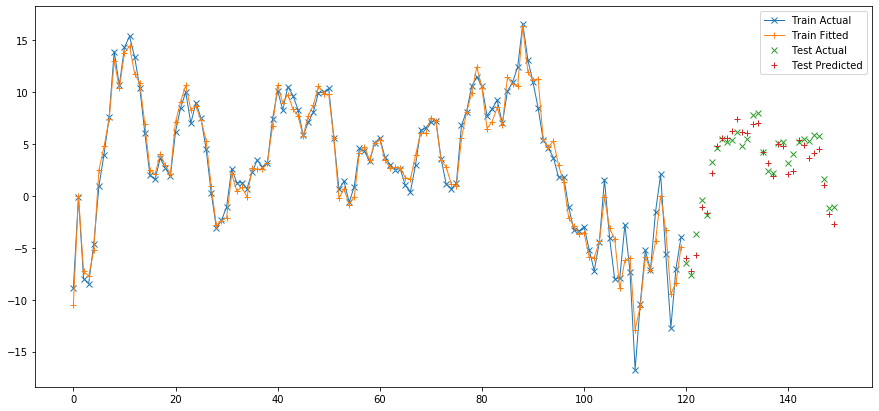

In [26]:
x_train, x_test = features.feature_set['kbest_x']['train'], features.feature_set['kbest_x']['test']

pl = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]
)

pl.fit(x_train, y_train)

y_fit = pl.predict(x_train)
train_mse = mean_squared_error(y_train, y_fit)
train_rmse = np.sqrt(train_mse)

y_pred = pl.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

train_r_sqd = pl.score(x_train, y_train)
train_resid = y_train - y_fit
norm_resid = normalize(train_resid.values.reshape(-1, 1), axis=0)

res = {
    'Train RMSE': np.sqrt(train_mse),
    'Test RMSE': np.sqrt(test_mse),
    'Train R^2': pl.score(x_train, y_train),
    'Residuals Mean': norm_resid.mean()
}

sns.scatterplot(data=norm_resid)

for metric, result in res.items():
    print(f'{metric}: {result}')
    
plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')
plt.plot(x_test.index, y_test, marker='x', linewidth=0, label='Test Actual')
plt.plot(x_test.index, y_pred, marker='+', linewidth=0, label='Test Predicted')
plt.legend()
plt.show()

## Recursive Feature Elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

`RFECV` performs RFE in a cross-validation loop to find the optimal number of features.

Index(['Spread', 'HPI_lag1', 'HPI_lag2', 'Unemp_lag4',
       'HPI_rolling_4_period_sum', 'HPI_rolling_6_period_sum',
       'HPI_rolling_8_period_sum', 'gdp_rolling_8_period_sum'],
      dtype='object')
Total number of features: 133
Number of selected features: 8
R-Squared: 0.919097014510345
RMSE: 1.8139239023429974


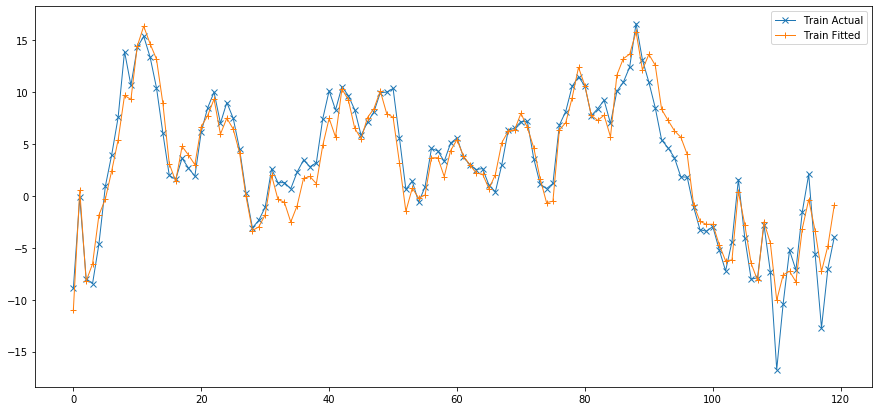

In [27]:
x_train, x_test = features.feature_set['x']['train'], features.feature_set['x']['test']

estimator = BayesianRidge()
selector = RFECV(estimator)
selector.fit(x_train, y_train)

feature_mask = selector.support_
used_features = x_train.columns[feature_mask]
print(used_features)
print(f'Total number of features: {x.shape[1]}')
print(f'Number of selected features: {len(used_features)}')

r_sqd = selector.estimator_.score(x_train[used_features], y_train)
print(f'R-Squared: {r_sqd}')

pred = selector.estimator_.predict(x_train[used_features])
mse = mean_squared_error(y_train, pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

y_fit = selector.estimator_.predict(x_train[used_features])

plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')

plt.legend()
plt.show()

features.add_feature_set('rfe_x', x_train[used_features], x_test[used_features])

Train RMSE: 1.8066192766704854
Test RMSE: 1.1554121668206285
Train R^2: 0.9197472910973747
Residuals Mean: -3.7007434154171884e-18


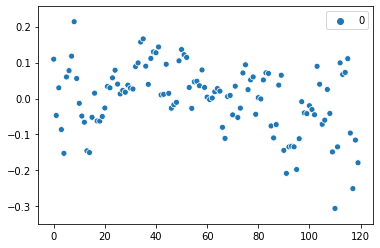

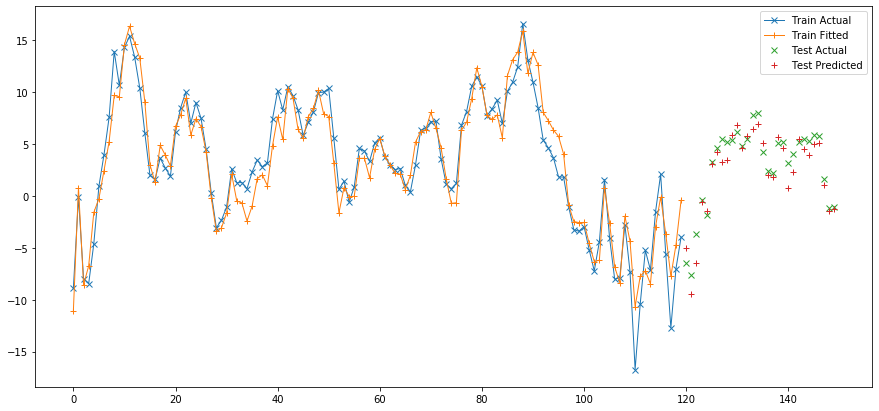

In [28]:
x_train, x_test = features.feature_set['rfe_x']['train'], features.feature_set['rfe_x']['test']

pl = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

pl.fit(x_train, y_train)

y_fit = pl.predict(x_train)
train_mse = mean_squared_error(y_train, y_fit)
train_rmse = np.sqrt(train_mse)

y_pred = pl.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

train_r_sqd = pl.score(x_train, y_train)
train_resid = y_train - y_fit
norm_resid = normalize(train_resid.values.reshape(-1, 1), axis=0)

res = {
    'Train RMSE': np.sqrt(train_mse),
    'Test RMSE': np.sqrt(test_mse),
    'Train R^2': pl.score(x_train, y_train),
    'Residuals Mean': norm_resid.mean()
}

sns.scatterplot(data=norm_resid)

for metric, result in res.items():
    print(f'{metric}: {result}')
    
plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')
plt.plot(x_test.index, y_test, marker='x', linewidth=0, label='Test Actual')
plt.plot(x_test.index, y_pred, marker='+', linewidth=0, label='Test Predicted')
plt.legend()
plt.show()

## Select Features from Model

`SelectFromModel` is a meta-transformer that can be used along with any estimator that has a `coef_` or `feature_importances_` attribute after fitting. The features are considered unimportant and removed, if the corresponding coef_ or feature_importances_ values are below the provided `threshold` parameter. Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a string argument. Available heuristics are “mean”, “median” and float multiples of these like “0.1*mean”.

In [29]:
x_train, x_test = features.feature_set['x']['train'], features.feature_set['x']['test']

estimator = RandomForestRegressor()
selector = SelectFromModel(estimator)
selector.fit(x, y)

selector_mask = selector.get_support()
selector_features = x.columns[selector_mask]
print(selector_features)

features.add_feature_set('from_model', x_train[selector_features], x_test[selector_features])

Index(['Spread', 'HPI:Spread', 'Unemp:Spread', 'gdp:Spread', 'HPI_lag1',
       'HPI_lag2', 'Spread_lag1', 'HPI_rolling_4_period_min',
       'HPI_rolling_6_period_std', 'HPI_rolling_6_period_min',
       'HPI_rolling_8_period_std', 'gdp_rolling_6_period_max',
       'Spread_rolling_4_period_sum', 'Spread_rolling_4_period_mean',
       'Spread_rolling_4_period_min', 'Spread_rolling_4_period_max',
       'HPI_1_period_diff', 'HPI_2_period_diff', 'Spread_8_period_pct_chg',
       'Spread_8_period_diff'],
      dtype='object')


Train RMSE: 1.7909311134622357
Test RMSE: 2.211501525117392
Train R^2: 0.9211350224668544
Residuals Mean: -2.312964634635743e-17


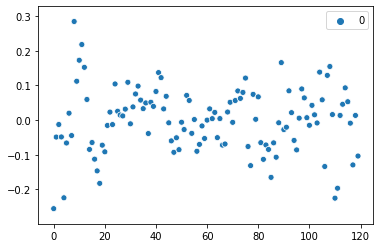

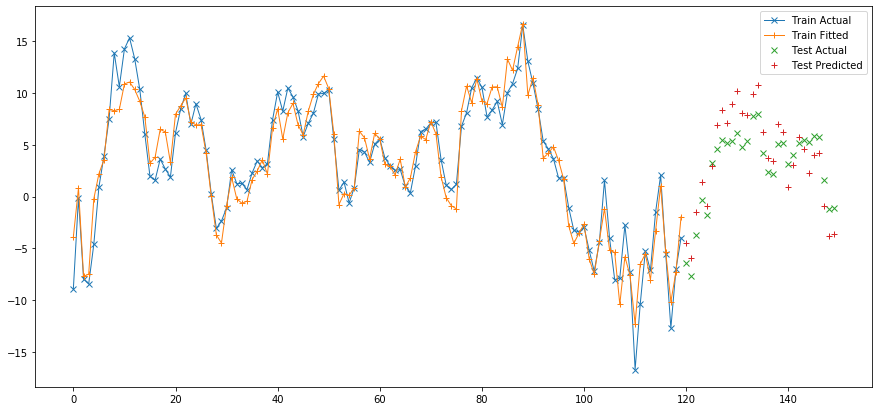

In [30]:
x_train, x_test = features.feature_set['from_model']['train'], features.feature_set['from_model']['test']

pl = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

pl.fit(x_train, y_train)

y_fit = pl.predict(x_train)
train_mse = mean_squared_error(y_train, y_fit)
train_rmse = np.sqrt(train_mse)

y_pred = pl.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

train_r_sqd = pl.score(x_train, y_train)
train_resid = y_train - y_fit
norm_resid = normalize(train_resid.values.reshape(-1, 1), axis=0)

res = {
    'Train RMSE': np.sqrt(train_mse),
    'Test RMSE': np.sqrt(test_mse),
    'Train R^2': pl.score(x_train, y_train),
    'Residuals Mean': norm_resid.mean()
}

sns.scatterplot(data=norm_resid)

for metric, result in res.items():
    print(f'{metric}: {result}')
    
plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')
plt.plot(x_test.index, y_test, marker='x', linewidth=0, label='Test Actual')
plt.plot(x_test.index, y_pred, marker='+', linewidth=0, label='Test Predicted')
plt.legend()
plt.show()

# Model Testing and Selection

The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter.  The GridSearchCV instance implements the usual estimator API: when “fitting” it on a dataset all the possible combinations of parameter values are evaluated and the best combination is retained.

GridSearchCV and RandomizedSearchCV allow searching over parameters of composite or nested estimators such as Pipeline, ColumnTransformer, VotingClassifier or CalibratedClassifierCV using a dedicated `estimator__parameter` syntax.  Here, `estimator` is the parameter name of the nested estimator, in this case base_estimator. If the meta-estimator is constructed as a collection of estimators as in pipeline.Pipeline, then `estimator` refers to the name of the estimator, see Nested parameters. In practice, there can be several levels of nesting.

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

- Convenience and encapsulation
 - You only have to call fit and predict once on your data to fit a whole sequence of estimators.

- Joint parameter selection
 - You can grid search over parameters of all estimators in the pipeline at once.

- Safety
 - Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘__’, as in the example below. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting it to ‘passthrough’ or None.

## GLM Pipeline

In [18]:
x_train, x_test = features.feature_set['rfe_x']['train'], features.feature_set['rfe_x']['test']

pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

search_space = [
    {
        'model': [LinearRegression()]
    },
    {
        'model': [Ridge()],
        'model__alpha': np.linspace(0.01, 10, 50)
    },
    {
        'model': [Lasso()],
        'model__alpha': np.linspace(0.01, 10, 50),
        'model__max_iter': [1e5]
    },
    {
        'model': [ElasticNet()],
        'model__alpha': np.linspace(0.01, 10, 50),
        'model__l1_ratio': np.linspace(0.05, 1., 20),
        'model__max_iter': [1e5]
    },
    {
        'model': [BayesianRidge()]
    },
    {
        'model': [ARDRegression()]
    },
    {
        'model': [LinearSVR()],
        'model__C': np.linspace(0.01, 10, 50),
        'model__max_iter': [1e6]
    },
    {
        'model': [SVR()],
        'model__C': np.linspace(0.01, 10, 50),
        'model__degree': [2, 3]
    },
    {
        'model': [Lars()],
        'model__normalize': [False],
        'model__n_nonzero_coefs': np.arange(1, 101)
    },
    {
        'model': [OrthogonalMatchingPursuit()],
        'model__normalize': [False],
        'model__n_nonzero_coefs': np.arange(1, 101)
    },
    {
        'model': [LassoLarsIC()]
    }
]

gridsearch = GridSearchCV(pipe, search_space, scoring='neg_mean_squared_error', cv=4, verbose=2, n_jobs=-1)
best_model = gridsearch.fit(x_train, y_train)

Fitting 4 folds for each of 1454 candidates, totalling 5816 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 5768 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 5816 out of 5816 | elapsed:   12.7s finished


In [19]:
best_model.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 Ridge(alpha=0.01, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

Train RMSE: 1.806623206938121
Test RMSE: 1.151924698475477
Train R^2: 0.919746941920355
Residuals Mean: -3.7007434154171884e-18


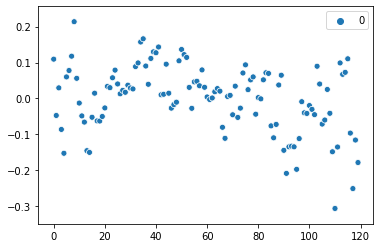

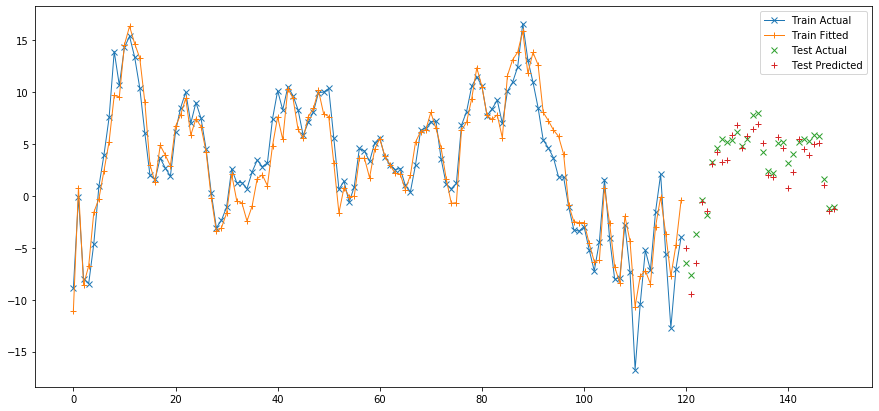

In [20]:
pl = best_model.best_estimator_

pl.fit(x_train, y_train)

y_fit = pl.predict(x_train)
train_mse = mean_squared_error(y_train, y_fit)
train_rmse = np.sqrt(train_mse)

y_pred = pl.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(mse)

train_r_sqd = pl.score(x_train, y_train)
train_resid = y_train - y_fit
norm_resid = normalize(train_resid.values.reshape(-1, 1), axis=0)

res = {
    'Train RMSE': np.sqrt(train_mse),
    'Test RMSE': np.sqrt(test_mse),
    'Train R^2': pl.score(x_train, y_train),
    'Residuals Mean': norm_resid.mean()
}

sns.scatterplot(data=norm_resid)

for metric, result in res.items():
    print(f'{metric}: {result}')
    
plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')
plt.plot(x_test.index, y_test, marker='x', linewidth=0, label='Test Actual')
plt.plot(x_test.index, y_pred, marker='+', linewidth=0, label='Test Predicted')
plt.legend()
plt.show()

In [21]:
best_model.best_estimator_.named_steps['model'].coef_

array([ 5.45146427,  1.60294061,  1.68379015, -1.73039861, -1.47591167,
       -2.44861815,  3.94768697,  3.90851201])

In [22]:
features.feature_set.keys()

dict_keys(['y', 'x', 'kbest10_x', 'kbest_x', 'rfe_x', 'from_model'])

## RF/GBM Pipeline

In [23]:
x_train, x_test = features.feature_set['from_model']['train'], features.feature_set['from_model']['test']


pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

search_space = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [100, 150, 200],
        'model__max_depth': [2, 3, 5, 10],
        'model__min_samples_leaf': [1, 3],
        'model__ccp_alpha': [0.1, 1, 3, 5]
    },
    {
        'model': [GradientBoostingRegressor()],
        'model__loss': ['ls', 'huber'],
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [100, 150, 200, 300],
        'model__subsample': [0.3, 0.6, 1.],
        'model__min_samples_leaf': [1, 2, 3],
        'model__max_depth': [2, 3, 5, 10],
        'model__ccp_alpha': [0.1, 1, 3, 5]
    },
    {
        'model': [AdaBoostRegressor()],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.1, 1.]
    }
]

gridsearch = GridSearchCV(pipe, search_space, scoring='neg_mean_squared_error', cv=4, verbose=2, n_jobs=-1)
best_model = gridsearch.fit(x_train, y_train)

Fitting 4 folds for each of 2406 candidates, totalling 9624 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 7906 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 9081 tasks      | 

In [24]:
best_model.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.1,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=2, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                       

Train RMSE: 1.022384690713509
Test RMSE: 1.9010974709723052
Train R^2: 0.9742986996750589
Residuals Mean: 0.008371263651049846


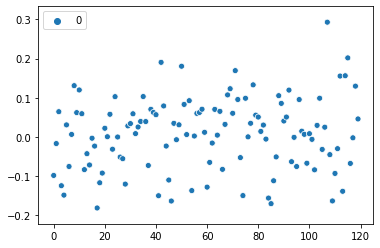

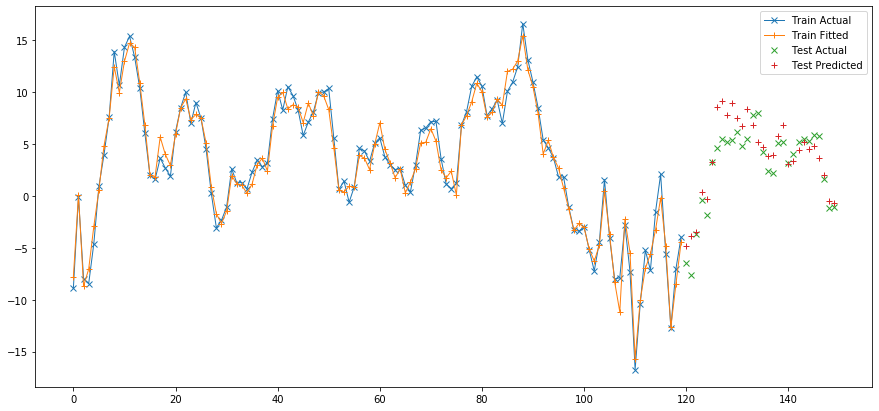

In [25]:
pl = best_model.best_estimator_

pl.fit(x_train, y_train)

y_fit = pl.predict(x_train)
train_mse = mean_squared_error(y_train, y_fit)
train_rmse = np.sqrt(train_mse)

y_pred = pl.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(mse)

train_r_sqd = pl.score(x_train, y_train)
train_resid = y_train - y_fit
norm_resid = normalize(train_resid.values.reshape(-1, 1), axis=0)

res = {
    'Train RMSE': np.sqrt(train_mse),
    'Test RMSE': np.sqrt(test_mse),
    'Train R^2': pl.score(x_train, y_train),
    'Residuals Mean': norm_resid.mean()
}

sns.scatterplot(data=norm_resid)

for metric, result in res.items():
    print(f'{metric}: {result}')
    
plt.figure(figsize=(15, 7))
plt.plot(x_train.index, y_train, marker='x', linewidth=1, label='Train Actual')
plt.plot(x_train.index, y_fit, marker='+', linewidth=1, label='Train Fitted')
plt.plot(x_test.index, y_test, marker='x', linewidth=0, label='Test Actual')
plt.plot(x_test.index, y_pred, marker='+', linewidth=0, label='Test Predicted')
plt.legend()
plt.show()

## What Feature List Scores Highest?

In [26]:
results = {}
set_list = ['kbest10_x', 'kbest_x', 'rfe_x', 'from_model']

for feature_set in set_list:

    x_train, x_test = features.feature_set[feature_set]['train'], features.feature_set[feature_set]['test']

    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]
    )

    search_space = [
        {
            'model': [LinearRegression()]
        },
        {
            'model': [Ridge()],
            'model__alpha': np.linspace(0.01, 10, 50)
        },
        {
            'model': [Lasso()],
            'model__alpha': np.linspace(0.01, 10, 50),
            'model__max_iter': [1e5]
        },
        {
            'model': [ElasticNet()],
            'model__alpha': np.linspace(0.01, 10, 50),
            'model__l1_ratio': np.linspace(0.05, 1., 20),
            'model__max_iter': [1e5]
        },
        {
            'model': [BayesianRidge()]
        },
        {
            'model': [ARDRegression()]
        },
        {
            'model': [LinearSVR()],
            'model__C': np.linspace(0.01, 10, 50),
            'model__max_iter': [1e6]
        },
        {
            'model': [SVR()],
            'model__C': np.linspace(0.01, 10, 50),
            'model__degree': [2, 3]
        },
        {
            'model': [Lars()],
            'model__normalize': [False],
            'model__n_nonzero_coefs': np.arange(1, 101)
        },
        {
            'model': [OrthogonalMatchingPursuit()],
            'model__normalize': [False],
            'model__n_nonzero_coefs': np.arange(1, 101)
        },
        {
            'model': [LassoLarsIC()]
        }
    ]

    gridsearch = GridSearchCV(pipe, search_space, scoring='neg_mean_squared_error', cv=4, verbose=2, n_jobs=-1)
    best_model = gridsearch.fit(x_train, y_train)

    best_estimator = gridsearch.best_estimator_
    best_score = gridsearch.best_score_
    
    res = {
        'estimator': best_estimator,
        'score': best_score
    }
    
    results[feature_set] = res

Fitting 4 folds for each of 1454 candidates, totalling 5816 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 5816 out of 5816 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s


Fitting 4 folds for each of 1454 candidates, totalling 5816 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 5816 out of 5816 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s


Fitting 4 folds for each of 1454 candidates, totalling 5816 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 5816 out of 5816 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s


Fitting 4 folds for each of 1454 candidates, totalling 5816 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 5816 out of 5816 | elapsed:   10.2s finished


In [27]:
pd.DataFrame(results).T

,estimator,score
kbest10_x,"(StandardScaler(copy=True, with_mean=True, wit...",-4.45519
kbest_x,"(StandardScaler(copy=True, with_mean=True, wit...",-3.94585
rfe_x,"(StandardScaler(copy=True, with_mean=True, wit...",-6.99079
from_model,"(StandardScaler(copy=True, with_mean=True, wit...",-5.05017
